<h1> I. PREPARATION (Etat : 100% Terminé) </h1>

<h2>I.1. Importations </h2>

In [1]:
# Pour rendre les fichiers Excels exploitables après téléchargement
import os
import re                                # Module d'opérations à base d'expressions rationnelles
import shutil                            # Module High-level file operations
import tempfile                          # Module de génération de fichiers et répertoires temporaires
from fnmatch      import fnmatch         # Librairie de filtrage par motif des noms de fichiers UNIX
from os           import listdir         # Pour lister les fichiers et sous-dossiers existants dans un répertoire
from os.path      import isfile, join    # Manipulation des noms de répertoires communs
from zipfile      import ZipFile         # Manipulation des fichiers ZIP

# Pour pré-traiter, traiter, et post-traiter les données
import cartopy as ctp                               # Pour manipuler les données géographiques
import datetime as dt                               # Pour manipuler les données temporelles
import dateparser
import matplotlib.pyplot as plt                     # Pour représenter les données
import numpy as np                                  # Pour manipuler les données
import pandas as pd                                 # Pour manipuler les données en forme de DataFrame
import requests                                     # Pour récupérer les données HTTP

from bs4 import BeautifulSoup                       # Pour exploiter les données d'un site internet à base de code HTML
from sklearn.metrics import r2_score                # 
from sklearn import preprocessing                   #
from sklearn.linear_model import LassoCV            #
from sklearn.linear_model import LinearRegression   # Pour études de régression linéaire

# Pour analyser et optimiser le temps de traitement
import time
import threading
from tqdm.auto import tqdm

- <u>Variables :</u>
>- BOOL_DirExist : Boolean validating the existence of the sub-directory
>- DIR_Data : Data directory
>- DIR_Main : Main directory
>- DIR_XLSRank : Directory containing daily rank Excel file
>- EXT_RankFile : String of Daily rank Excel file extension
>- FILE : String of FileName.FileExt
>- LIST_FileID : ID of the file in string date format "AAAAMMDD_HHMMSS"
>- LIST_FilesTemp : Temporary file liste to compare
>- LIST_FilesToDwnld : Missing files list to download
>- LIST_RankDate : List of ranking dates format"AAAA-MM-DD HH:MM:SS"
>- LIST_SoupURLRank : List of daily ranks in the URL
>- LIST_Time : List of date as datetime.datetime 
>- SOUP_URLRank : Soup of the URL rank
>- URL_Ranks : URL of ranks
>- URL_DwnldRank : Download link of ranks Excel files (without file ID and .ext)

- <u>Functions (def):</u>
>- CHECK_DATA_DIR : Check that data directories exist
>- CHECK_FILE_LIST : Check that all excel ranking files exist in the subdirectory
>- CONVERT_TIME_FORMAT : Convert date format
>- DWNLD_DAILY_RANK_FILES : Download Excel ranking files
>- GET_RANKING_DATE_LIST : Extract list of ranking date in AAAA-MM-DD HH:MM:SS format
>- UPDATE_FORMAT : Resolve the problem to open downloaded Excel files


<h2>I.2. Définitions des répertoires, liens internet, et type de fichiers</h2>

In [2]:
# Directories & SubDirectories
DIR_Main = os.getcwd()        # Main directory
DIR_XLSRank = 'DataRank_2021' # Sub-directory containing xlsx daily rank files

#DataSkipperDir = 'DataSkipper_2021'

# Uniform Resource Locators (URL) of Vendee Globe 2020-2021 data
URL_Ranks = "https://www.vendeeglobe.org/fr/classement"
URL_DwnldRank = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_"
URL_Skippers = "https://www.vendeeglobe.org/fr/glossaire"

# FilesType
EXT_RankFile = ".xlsx"

<h2>I.3. Outils de conversion </h2>

In [3]:
def CONVERT_TIME_FORMAT (LIST_URL_Time :'YYYY-MM-DD hh:mm:ss')\
      ->'datetime.datetime(YYYY,M,D,H,M),[YYYYMMDD_HHMMSS]':
    
    LIST_Time =[]               # Daily rank date list extracted from URL_Rank
    LIST_FileID = []            # File ID list
    for i in LIST_URL_Time:     # Converting all the daily rank date formats
        LIST_Time.append(dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S"))
        LIST_FileID.append(dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").
                           strftime("%Y%m%d_%H%M%S"))
    return LIST_Time,LIST_FileID

<h2>I.4. Gestion des répertoires et des fichiers </h2>

In [4]:
def CHECK_DATA_DIR(DIR_Main:'Dir_String', TYPE_Data:'Type_String')\
      ->'BOOL_ExistDir, DIR_Data':
    
    DIR_Data = os.path.join(DIR_Main, TYPE_Data)
    if not os.path.exists(DIR_Data):   # Make subdirectory if doesn't exist
        os.mkdir(DIR_Data)
        BOOL_DirExist = False
    else:
        BOOL_DirExist = True           # Else pass
    print("The subdirectory exists "+TYPE_Data+" exists :"+\
          str(np.where(BOOL_DirExist==True,"OK","NOK")))
    return BOOL_DirExist, DIR_Data

In [5]:
def GET_RANKING_DATE_LIST(URL_Ranks : 'URL_String')\
      ->'List of ranking date in AAAA-MM-DD HH:MM:SS format':
    
    
    SOUP_URLRank = BeautifulSoup(requests.get(URL_Ranks).
                                 content.decode('utf-8'))            #Get Soup
    LIST_SoupURLRank = SOUP_URLRank\
          .findAll('option')                        #Extract only options list
    LIST_RankDate = []
    for iLIST_SoupURLRank in LIST_SoupURLRank:     #Generate ranking date list
        LIST_RankDate.append(iLIST_SoupURLRank.text[2:])
    LIST_RankDate = np.unique(LIST_RankDate[1:-1])        #Delete duplications
    print("Number of daily ranking files : " + str(len(LIST_RankDate)))
    return LIST_RankDate

In [6]:
def UPDATE_FORMAT(FILE : "FileName.FileExt string",
                  name_filter : "Name filer string",
                  change : 'string')\
      ->'Nothing : Excel files are updated to be workable':
    DIR_temp = tempfile.mkdtemp()
    try:
        NAME_temp = os.path.join(DIR_temp, 'new.zip')
        with ZipFile(FILE, 'r') as r, ZipFile(NAME_temp, 'w') as w:
            for item in r.infolist():
                DATA = r.read(item.filename)           
                DATA = change(DATA)
                w.writestr(item, DATA)
        shutil.move(NAME_temp, FILE)
    finally:
        shutil.rmtree(DIR_temp)

In [7]:
def DWNLD_DAILY_RANK_FILES(URL_DwnldRank : 'DownloadingURL_String',
                           LIST_FileID : 'List of string containing files ID',
                           EXT_RankFile : '.ext_file String',
                           DIR_Data : 'Data Directory string',
                           DIR_Main : 'Main Directory string')\
      -> 'Nothing : Excel files downloaded and saved in data directory':
    os.chdir(DIR_Data)                                    # Go to subdirectory
    with tqdm(range(len(LIST_FileID)),
              desc = "Downloading progress bar")\
              as outer :
        for iLIST_FileID in LIST_FileID:    # Download each Excel ranking file
            resp = requests.get(URL_DwnldRank+iLIST_FileID+EXT_RankFile)
            FILE = "vendeeglobe_"+iLIST_FileID+EXT_RankFile
            with open(FILE,'wb')as file:
                file.write(resp.content)
            UPDATE_FORMAT(FILE,name_filter='xl/styles.xml',
                          change=lambda d:re.sub(b'xxid="\d*"',b"",d))
            outer.update()
    os.chdir(DIR_Main)

In [8]:
def CHECK_FILE_LIST(DIR_Main: 'Main directory string',
                    DIR_Data: 'Ranking excel directory string',
                    LIST_FileID: 'List of excel file ID string')\
      -> 'List of string of excel file ID to download':  
    LIST_FilesTemp = [f for f in listdir(DIR_Data)\
                      if isfile(join(DIR_Data,f))]
    LIST_FilesToDwnld = []
    for iLIST_FilesTemp in LIST_FileID:
        if not str("vendeeglobe_"+iLIST_FilesTemp+".xlsx") in LIST_FilesTemp:
            LIST_FilesToDwnld.append(iLIST_FilesTemp)
    return LIST_FilesToDwnld

In [9]:
'''MAIN DOWNLOADING DATA'''

BOOL_DirExist, DIR_Data = CHECK_DATA_DIR(DIR_Main,DIR_XLSRank)
LIST_RankDate = GET_RANKING_DATE_LIST(URL_Ranks)
LIST_Time, LIST_FileID = CONVERT_TIME_FORMAT(LIST_RankDate)
"""if BOOL_DirExist == False:
    print('Subdirectory "Datarank_2021" complete : NOK')
    print('Downloading ', len(LIST_FileID),
          ' Excel daily ranking files')
    DWNLD_DAILY_RANK_FILES(URL_DwnldRank,
                           LIST_FileID,
                           EXT_RankFile,
                           DIR_Data,
                           DIR_Main)
else :"""
LIST_FilesToDwnld = CHECK_FILE_LIST(DIR_Main,
                                    DIR_Data,
                                    LIST_FileID)
if len(LIST_FilesToDwnld)!=0:
    print('Subdirectory "Datarank_2021" complete : NOK')
    print('Downloading ',len(LIST_FilesToDwnld),
          ' missing Excel daily ranking files')
    DWNLD_DAILY_RANK_FILES(URL_DwnldRank,
                          LIST_FilesToDwnld,
                          EXT_RankFile,
                          DIR_Data,
                          DIR_Main)
    
print("-------------------------------------------------")
print('Subdirectory "Datarank_2021" created : OK')
print('Subdirectory "Datarank_2021" complete : OK')

The subdirectory exists DataRank_2021 exists :OK
Number of daily ranking files : 702
-------------------------------------------------
Subdirectory "Datarank_2021" created : OK
Subdirectory "Datarank_2021" complete : OK


<h1>Chargement des données excel en DF (En cours)</h1>

In [115]:
def CLASS_XLS_DATA(iLIST_FileID, iLIST_RankDate):
    FILE_Name = "vendeeglobe_"+iLIST_FileID+".xlsx"
    DF_RANK = pd.read_excel(FILE_Name)
    BOOL_RaceState= [False, False]    # Boolean vect. confirming if data in file containt [Race progressing, Race finished]
    if DF_RANK.loc[DF_RANK["Unnamed: 5"]=="Latitude\nLatitude"].index.values:
        BOOL_RaceState[0] = True
    if DF_RANK.loc[DF_RANK['Unnamed: 8']=="Temps de course\nRace time"].index.values:
        BOOL_RaceState[1] = True
    #print(RaceState)
    
    if BOOL_RaceState == [True, False]:
        idx_RACE_Prog = DF_RANK.loc[DF_RANK["Unnamed: 5"]=="Latitude\nLatitude"].index.values[0]
        DF_Daily_Rank = pd.read_excel(FILE_Name,header = [idx_RACE_Prog, idx_RACE_Prog+1],nrows=33)
        DF_FINAL_RANK = []

    elif BOOL_RaceState == [True,True]:
        idx_RACE_Prog = DF_RANK.loc[DF_RANK["Unnamed: 5"]=="Latitude\nLatitude"].index.values[0]
        idx_RACE_end = DF_RANK.loc[DF_RANK['Unnamed: 8']=="Temps de course\nRace time"].index.values[0]+2
        DF_FINAL_RANK = pd.read_excel(FILE_Name,header = [idx_RACE_end-1,idx_RACE_end], nrows=idx_RACE_Prog-idx_RACE_end-1)
        DF_Daily_Rank = pd.read_excel(FILE_Name,header = [idx_RACE_Prog, idx_RACE_Prog+1],nrows=33-(idx_RACE_Prog-idx_RACE_end-1))

    elif BOOL_RaceState == [False, True]:
        idx_RACE_end = DF_RANK.loc[DF_RANK['Unnamed: 8']=="Temps de course\nRace time"].index.values[0]+2
        DF_FINAL_RANK = pd.read_excel(FILE_Name,header = [idx_RACE_end-1,idx_RACE_end], nrows=33)
        DF_Daily_Rank = []
        
    return DF_Daily_Rank, DF_Final_Rank

In [238]:
print ("Loading daily rank file and generating DataFrames")
with tqdm(range(len(LIST_FileID)),
              desc = "Loading progress bar")\
              as outer :
    DF_DailyRank = pd.DataFrame()
    for iDailyRank in range (len(LIST_FileID)):    # Download each Excel ranking file
        iDF_Daily_Rank, DF_Final_Rank = CLASS_XLS_DATA(LIST_FileID[iDailyRank], LIST_RankDate[iDailyRank])
        if iDailyRank < len(LIST_FileID)-1:
            iDF_Daily_Rank['Unnamed: 0_level_0', 'Unnamed: 0_level_1']=LIST_RankDate[iDailyRank]
        DF_DailyRank = DF_DailyRank.append(iDF_Daily_Rank)
        outer.update()
    DF_DailyRank['Nat. / Voile\nNat. / Sail'] = DF_DailyRank['Nat. / Voile\nNat. / Sail']\
                                                    .apply(lambda s: s.str.replace('FR\n',''))\
                                                    .apply(lambda s: s.str.replace('\n',''))
    DF_DailyRank = DF_DailyRank.drop(("Skipper / Bateau\nSkipper / crew", 'Heure FR\nHour FR'),axis=1)
    print ("Generation of Ranking DataFrames finished")

Loading daily rank file and generating DataFrames


Loading progress bar:   0%|          | 0/702 [00:00<?, ?it/s]

C:\Users\alexa\AppData\Local\Temp/ipykernel_16896/2846714442.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if DF_RANK.loc[DF_RANK['Unnamed: 8']=="Temps de course\nRace time"].index.values:


Generation of Ranking DataFrames finished


C:\Users\alexa\AppData\Local\Temp/ipykernel_16896/2846714442.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if DF_RANK.loc[DF_RANK["Unnamed: 5"]=="Latitude\nLatitude"].index.values:


In [239]:
DF_DailyRank[:].head()

Unnamed: 0_level_0         Rang\nRank Nat. / Voile\nNat. / Sail  \
    Unnamed: 0_level_1 Unnamed: 1_level_1        Unnamed: 2_level_1   
0  2020-11-08 14:00:00                  1                    FRA 18   
1  2020-11-08 14:00:00                  2                    MON 10   
2  2020-11-08 14:00:00                  3                     FRA 8   
3  2020-11-08 14:00:00                  4                    FRA 59   
4  2020-11-08 14:00:00                  5                    FRA 53   

                    Skipper / Bateau\nSkipper / crew                     \
                                  Unnamed: 3_level_1 Latitude\nLatitude   
0                      Louis Burton\nBureau Vallée 2         46°24.46'N   
1  Boris Herrmann\nSeaexplorer - Yacht Club De Mo...         46°24.34'N   
2                              Jérémie Beyou\nCharal         46°24.91'N   
3                           Thomas Ruyant\nLinkedOut         46°24.71'N   
4                      Maxime Sorel\nV And B Mayenne         46°24.59'N   

                       Depuis 30 minutes\nSince 30 minutes                 \
  Longitude\nLongitude                        Cap\nHeading Vitesse\nSpeed   
0           01°50.48'W                                241°       17.7 kts   
1           01°49.82'W                                241°       11.1 kts   
2           01°49.99'W                                244°       15.5 kts   
3           01°49.68'W                                244°       13.2 kts   
4           01°49.56'W                                246°       10.9 kts   

                                \
   VMG\nVMG Distance\nDistance   
0  17.5 kts             0.3 nm   
1  10.9 kts             0.4 nm   
2  15.5 kts             0.5 nm   
3  13.1 kts             0.7 nm   
4  10.9 kts             0.2 nm   

  Depuis le dernier classement\nSince the the last report                 \
                                             Cap\nHeading Vitesse\nSpeed   
0                                               357°             0.0 kts   
1                                               357°             0.0 kts   
2                                               357°             0.0 kts   
3                                               357°             0.0 kts   
4                                               357°             0.0 kts   

                              Depuis 24 heures\nSince 24 hours                 \
  VMG\nVMG Distance\nDistance                     Cap\nHeading Vitesse\nSpeed   
0  0.0 kts          2788.0 nm                             201°        0.3 kts   
1  0.0 kts          2787.9 nm                             196°        0.3 kts   
2  0.0 kts          2788.5 nm                             199°        0.2 kts   
3  0.0 kts          2788.3 nm                             196°        0.2 kts   
4  0.0 kts          2788.1 nm                             195°        0.8 kts   

                                              DTF                 DTL  
  VMG\nVMG Distance\nDistance Unnamed: 19_level_1 Unnamed: 20_level_1  
0  0.3 kts             6.1 nm          24293.9 nm              0.0 nm  
1  0.2 kts             6.0 nm          24294.2 nm              0.4 nm  
2  0.2 kts             5.5 nm          24294.3 nm              0.5 nm  
3  0.2 kts             5.6 nm          24294.5 nm              0.6 nm  
4  0.7 kts             5.8 nm          24294.5 nm              0.6 nm

In [241]:
test = DF_DailyRank

In [235]:
DF_DailyRank.drop(("Skipper / Bateau\nSkipper / crew", 'Heure FR\nHour FR'),axis=1)

Unnamed: 0_level_0         Rang\nRank Nat. / Voile\nNat. / Sail  \
     Unnamed: 0_level_1 Unnamed: 1_level_1        Unnamed: 2_level_1   
0   2020-11-08 14:00:00                  1                    FRA 18   
1   2020-11-08 14:00:00                  2                    MON 10   
2   2020-11-08 14:00:00                  3                     FRA 8   
3   2020-11-08 14:00:00                  4                    FRA 59   
4   2020-11-08 14:00:00                  5                    FRA 53   
..                  ...                ...                       ...   
4   2021-03-05 04:00:00                RET                   FRA 109   
5   2021-03-05 04:00:00                RET                     FRA 4   
6   2021-03-05 04:00:00                RET                    GBR 99   
7   2021-03-05 04:00:00                RET                    FRA 85   
8   2021-03-05 04:00:00                RET                     FRA 6   

                     Skipper / Bateau\nSkipper / crew                     \
                                   Unnamed: 3_level_1 Latitude\nLatitude   
0                       Louis Burton\nBureau Vallée 2         46°24.46'N   
1   Boris Herrmann\nSeaexplorer - Yacht Club De Mo...         46°24.34'N   
2                               Jérémie Beyou\nCharal         46°24.91'N   
3                            Thomas Ruyant\nLinkedOut         46°24.71'N   
4                       Maxime Sorel\nV And B Mayenne         46°24.59'N   
..                                                ...                ...   
4                Samantha Davies\nInitiatives - Coeur                NaN   
5                       Sébastien Simon\nARKEA PAPREC                NaN   
6                             Alex Thomson\nHUGO BOSS                NaN   
7                                Kevin Escoffier\nPRB                NaN   
8                   Nicolas Troussel\nCORUM L'Épargne                NaN   

                        Depuis 30 minutes\nSince 30 minutes                 \
   Longitude\nLongitude                        Cap\nHeading Vitesse\nSpeed   
0            01°50.48'W                                241°       17.7 kts   
1            01°49.82'W                                241°       11.1 kts   
2            01°49.99'W                                244°       15.5 kts   
3            01°49.68'W                                244°       13.2 kts   
4            01°49.56'W                                246°       10.9 kts   
..                  ...                                 ...            ...   
4                   NaN                                 NaN            NaN   
5                   NaN                                 NaN            NaN   
6                   NaN                                 NaN            NaN   
7                   NaN                                 NaN            NaN   
8                   NaN                                 NaN            NaN   

                                 \
    VMG\nVMG Distance\nDistance   
0   17.5 kts             0.3 nm   
1   10.9 kts             0.4 nm   
2   15.5 kts             0.5 nm   
3   13.1 kts             0.7 nm   
4   10.9 kts             0.2 nm   
..       ...                ...   
4        NaN                NaN   
5        NaN                NaN   
6        NaN                NaN   
7        NaN                NaN   
8        NaN                NaN   

   Depuis le dernier classement\nSince the the last report                 \
                                              Cap\nHeading Vitesse\nSpeed   
0                                                357°             0.0 kts   
1                                                357°             0.0 kts   
2                                                357°             0.0 kts   
3                                                357°             0.0 kts   
4                                                357°             0.0 kts   
..                                                ...                

<h1>Chargement des données de voiliers (90% terminé)</h1>

<u>A voir</u>

Voir pour l'indexage du DF :
- Par nom de skipper
- Par nom de bateau
- Par numéro de voile

Avis personnel : Numéro de voile probablement plus facilement identifiable pour les raisons suivantes:
- Longueur du string des numéro de voile courte. Référence unique (on peut changer de marin sur ce même bateau, ou donner un nouveau nom au voilier, ça ne changera pas la référence de la voile)
- Nom de skipper réduit pour certains (diminutif, ex:Alexandre --> Alex)
- Nom de bateau : long string (idem pour certains noms de marin), risque de différence élevé (donc plus difficile à merger)

In [21]:
def GEN_SEPCS_DF (URL_Skipper):
    # Paramètres des types de données à extraire
    PARAM_Data = {
        "BoatSpecs" : ['ul', "class", "boats-list__popup-specs-list"],
        "Nom voilier" : ['h3',"class","boats-list__boat-name"],
        "Nom skipper" : ["span","class", "boats-list__skipper-name"]
    }
    
    # Fonction d'extraction de données techniques spécifiques
    #(BoatSpecs, BoatName, SkipperName) sous forme de list
    def LIST_SOUP (URL_Skipper, PARAM_Data,iPARAM_Data):
        return BeautifulSoup(requests.get(URL_Skipper).content\
                                 .decode("utf-8")).findAll(
                                    PARAM_Data[iPARAM_Data][0],
                                    {PARAM_Data[iPARAM_Data][1]:
                                     PARAM_Data[iPARAM_Data][2]})
    # Création d'un DF Spécifications techniques du voilier vierge
    DF_TechSpecs=pd.DataFrame()
    
    # Remplissage du DF
    for iPARAM_Data in PARAM_Data:
        LIST_Soup = LIST_SOUP (URL_Skipper, PARAM_Data, iPARAM_Data)
        # Remplir d'abord les données techniques du voilier
        #(Num. voile, Anciens nom, Architece, Chantier, Date lanc., Longueur,...)
        if iPARAM_Data == list(PARAM_Data.keys())[0]:
            idx = 0
            for iLIST_Soup in LIST_Soup:
                iDATA,iVAL = np.transpose([string.split(' : ',1) for string
                                           in iLIST_Soup.text.split("\n")[1:-1]])
                DF_TechSpecs = pd.concat([DF_TechSpecs,
                                          pd.DataFrame([iVAL],columns = iDATA)],
                                             ignore_index=True)
                idx+=1
        # Ajouter ensuite les colonnes Nom de voilier, et nom du marin;
        #puis les mettre en premières colonnes
        else:
            DF_TechSpecs[iPARAM_Data] = [string.text for string in LIST_Soup]
            DF_TechSpecs = DF_TechSpecs[DF_TechSpecs.columns.tolist()[-1:]+
                                        DF_TechSpecs.columns.tolist()[:-1]]
    
    # Homogénéisation des données
       # liste des valeurs [init, new] et des unités à supprimer
        #suivant le nom de la colonne 
    VAL_ToReplace = {"Date de lancement":[], # pour reconvertion des dates
                    "Anciens noms du bateau":[np.nan,''],"Voile quille":[np.nan,''], # Pour remplacement des valeurs
                    "Nombre de dérives":[["foiler", "2 asymétriques"],['foils', "2"]], # Pour remplacement des valeurs
                    "Longueur":[' m'],"Largeur" :[' m'],"Tirant d'eau":[' m'],"Hauteur mât":[' m'], # Suppresion des unités de longueur
                    "Surface de voiles au près":[' m2', ' m²'],"Surface de voiles au portant":[' m2', ' m²'], #Suppression des unités de surface
                    "Déplacement (poids)":[' t', ' tonnes']} #Suppresion des unités de masse
    for iCOL in VAL_ToReplace:
        if iCOL in ["Anciens noms du bateau","Voile quille","Nombre de dérives"]:      
            DF_TechSpecs[iCOL] = DF_TechSpecs[iCOL]\
                                    .replace(VAL_ToReplace[iCOL][0],
                                             VAL_ToReplace[iCOL][1])
        elif "Date de lancement" in iCOL:
            DF_TechSpecs[iCOL] = DF_TechSpecs[iCOL].apply(dateparser.parse)
        else :
            for iUNIT in VAL_ToReplace[iCOL]:
                DF_TechSpecs[iCOL] = DF_TechSpecs[iCOL].str.strip(iUNIT)
            if "Déplacement (poids)" in iCOL:
                DF_TechSpecs[iCOL] = DF_TechSpecs[iCOL].str\
                                        .replace('[a-zA-Z]', '0', regex=True)
            DF_TechSpecs[iCOL] = DF_TechSpecs[iCOL].str.replace(',','.')
            DF_TechSpecs[iCOL] = DF_TechSpecs[iCOL].astype('float')
    # Repositionnement des unités de dimensionnement dans l'entête de certaines colonnes
    TITLE_ToReplace = {"Longueur":'Longueur [m]',
                   "Largeur" :'Largeur m',
                   "Tirant d'eau":"Tirant d'eau [m]",
                   "Hauteur mât":'Hauteur mât [m]',
                   "Surface de voiles au près":'Surface de voiles au près [m²]',
                   "Surface de voiles au portant":'Surface de voiles au portant [m²]',
                   "Déplacement (poids)":'Déplacement (poids) [t]'}
    DF_TechSpecs = DF_TechSpecs.rename(columns = TITLE_ToReplace)
    return DF_TechSpecs

In [22]:
DF_TechSpecs = GEN_SEPCS_DF(URL_Skippers)

DF_TechSpecs

,Nom skipper,Nom voilier,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur [m],Largeur m,Tirant d'eau [m],Déplacement (poids) [t],Nombre de dérives,Hauteur mât [m],Voile quille,Surface de voiles au près [m²],Surface de voiles au portant [m²]
0,Fabrice AMEDEO,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-08-01,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0
1,Romain ATTANASIO,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-03-08,18.28,5.80,4.5,9.0,2,28.0,acier forgé,80.0,560.0
2,Alexia BARRIER,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,18.28,5.54,4.5,9.0,2,29.0,acier,60.0,580.0
3,Yannick BESTAVEN,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015-03-12,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0
4,Jérémie BEYOU,CHARAL,08,,VPLP,CDK Technologies,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0
5,Arnaud BOISSIÈRES,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,2007-08-03,18.28,5.65,4.5,7.9,foils,29.0,basculante avec vérin,300.0,610.0
6,Louis BURTON,BUREAU VALLEE 2,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,2015-06-09,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0
7,Didac COSTA,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,2000-02-02,18.28,5.30,4.5,8.9,2,26.0,acier,40.0,470.0
8,Manuel COUSIN,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),2007-02-02,18.28,5.80,4.5,9.0,2,28.5,basculante sur vérin hydraulique,70.0,560.0
9,Clarisse CREMER,BANQUE POPULAIRE X,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,2011-03-01,18.28,5.70,4.5,7.7,2,29.0,acier forgé,340.0,570.0


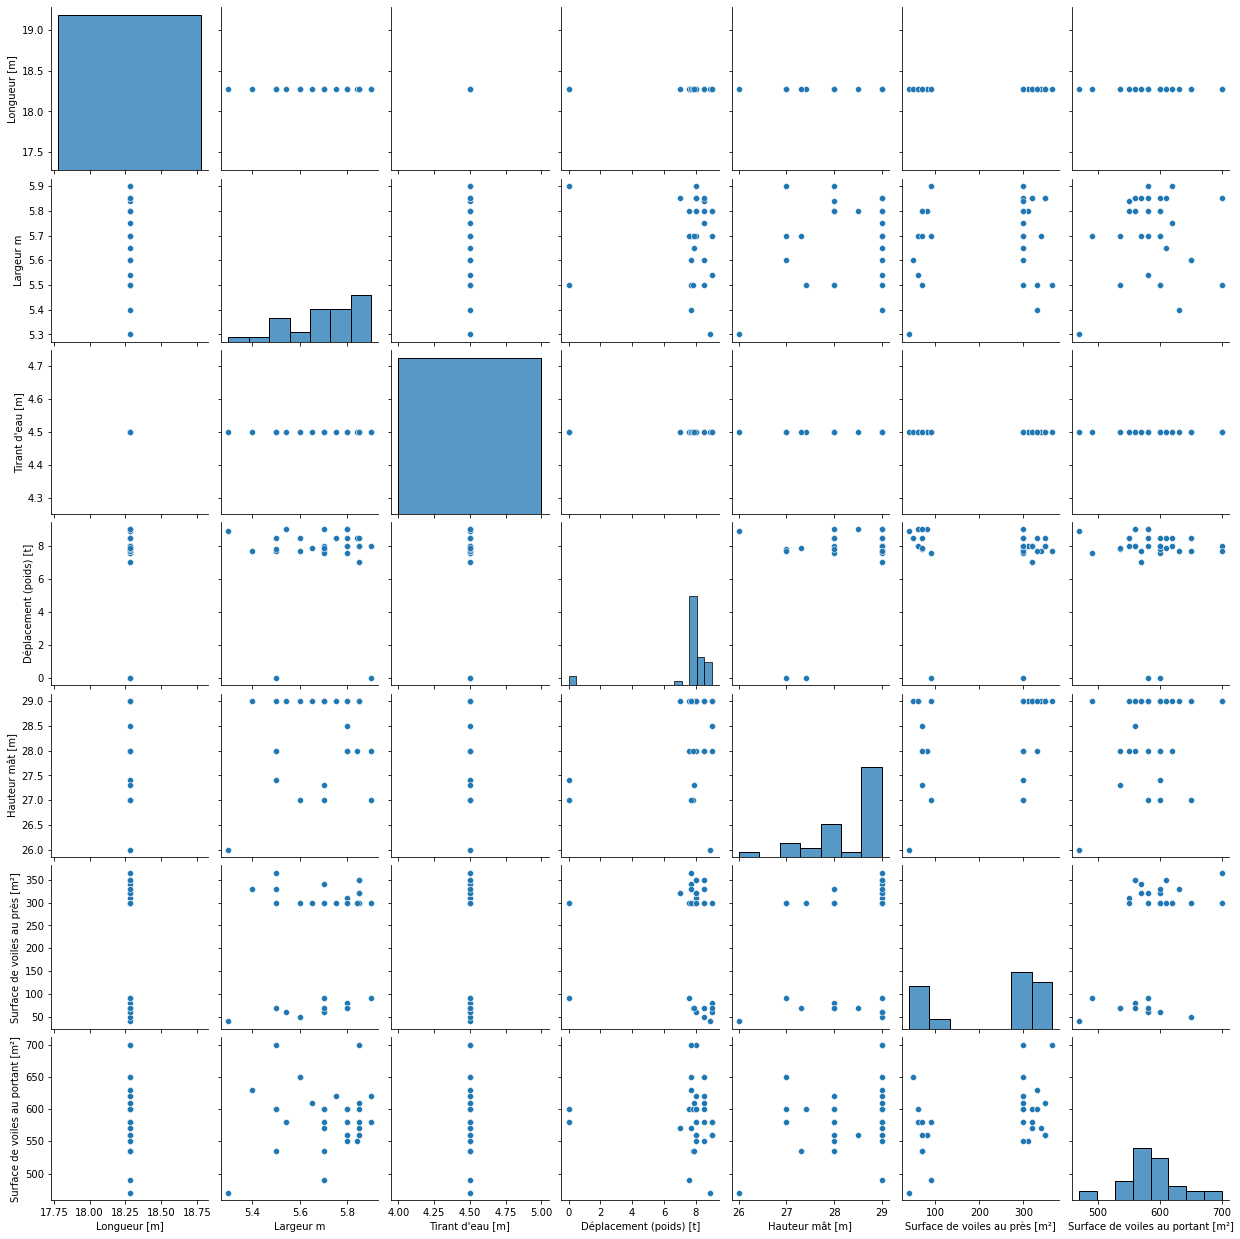

In [49]:
import seaborn as sns

i = ['Date de lancement',
     'Longueur [m]',
     "Largeur m",
     "Tirant d'eau [m]",
     "Déplacement (poids) [t]",
     "Nombre de dérives",
     "Hauteur mât [m]",
     "Voile quille",
     "Surface de voiles au près [m²]",
     "Surface de voiles au portant [m²]"]
sns.pairplot(DF_TechSpecs[i])

In [48]:
pd.merge(test_Encourse, DF_TechSpecs, on = "Numéro de voile")

C:\Users\alexa\AppData\Local\Temp/ipykernel_16896/3324686284.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  pd.merge(test_Encourse, DF_TechSpecs, on = "Numéro de voile")


KeyError: 'Numéro de voile'

In [27]:
dt.datetime.strptime(LIST_Time, '%Y-%m-%d %h:%m')

TypeError: strptime() argument 1 must be str, not list

In [28]:
[dt.datetime.strptime(x, '%Y-%m-%d %h:%m') for x in LIST_Time]

TypeError: strptime() argument 1 must be str, not datetime.datetime

In [36]:
for x in LIST_Time :
    pass
print(x)

2021-03-05 08:00:00


In [42]:
LIST_Time[0]

datetime.datetime(2020, 11, 8, 14, 0)

In [43]:
print(LIST_Time[0])

2020-11-08 14:00:00


In [51]:
LIST_FileID

['20201108_140000',
 '20201108_150000',
 '20201108_170000',
 '20201108_210000',
 '20201109_040000',
 '20201109_080000',
 '20201109_110000',
 '20201109_140000',
 '20201109_170000',
 '20201109_210000',
 '20201110_040000',
 '20201110_080000',
 '20201110_110000',
 '20201110_140000',
 '20201110_170000',
 '20201110_210000',
 '20201111_040000',
 '20201111_080000',
 '20201111_110000',
 '20201111_140000',
 '20201111_170000',
 '20201111_210000',
 '20201112_040000',
 '20201112_080000',
 '20201112_110000',
 '20201112_140000',
 '20201112_170000',
 '20201112_210000',
 '20201113_040000',
 '20201113_080000',
 '20201113_110000',
 '20201113_140000',
 '20201113_170000',
 '20201113_210000',
 '20201114_040000',
 '20201114_080000',
 '20201114_110000',
 '20201114_140000',
 '20201114_170000',
 '20201114_210000',
 '20201115_040000',
 '20201115_080000',
 '20201115_110000',
 '20201115_140000',
 '20201115_170000',
 '20201115_210000',
 '20201116_040000',
 '20201116_080000',
 '20201116_110000',
 '20201116_140000',


In [50]:
LIST_RankDate

array(['2020-11-08 14:00:00', '2020-11-08 15:00:00',
       '2020-11-08 17:00:00', '2020-11-08 21:00:00',
       '2020-11-09 04:00:00', '2020-11-09 08:00:00',
       '2020-11-09 11:00:00', '2020-11-09 14:00:00',
       '2020-11-09 17:00:00', '2020-11-09 21:00:00',
       '2020-11-10 04:00:00', '2020-11-10 08:00:00',
       '2020-11-10 11:00:00', '2020-11-10 14:00:00',
       '2020-11-10 17:00:00', '2020-11-10 21:00:00',
       '2020-11-11 04:00:00', '2020-11-11 08:00:00',
       '2020-11-11 11:00:00', '2020-11-11 14:00:00',
       '2020-11-11 17:00:00', '2020-11-11 21:00:00',
       '2020-11-12 04:00:00', '2020-11-12 08:00:00',
       '2020-11-12 11:00:00', '2020-11-12 14:00:00',
       '2020-11-12 17:00:00', '2020-11-12 21:00:00',
       '2020-11-13 04:00:00', '2020-11-13 08:00:00',
       '2020-11-13 11:00:00', '2020-11-13 14:00:00',
       '2020-11-13 17:00:00', '2020-11-13 21:00:00',
       '2020-11-14 04:00:00', '2020-11-14 08:00:00',
       '2020-11-14 11:00:00', '2020-11-14 14:0